In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
import os

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys  

# os.environ['OPENBLAS_NUM_THREADS'] = '1'

class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [2]:
# df = uproot.lazy('/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/QCD/QCD_HT1000to1500/154.root:Events')

In [231]:
events = NanoEventsFactory.from_root(
    '/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/TTJets/TTJets/merged_2.root',
    # '/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/QCD/QCD_HT1000to1500/merged_2.root',
).events()

events = events[ak.num(events.FatJet) >= 1]
# events = ak.concatenate([NanoEventsFactory.from_root(
#     f'/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/QCD/QCD_HT1000to1500/{i}.root',
# ).events() for i in range(10)], axis=0)

In [232]:
events

<NanoEventsArray [<event 1:100084:259915555>, ... ] type='330706 * event'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

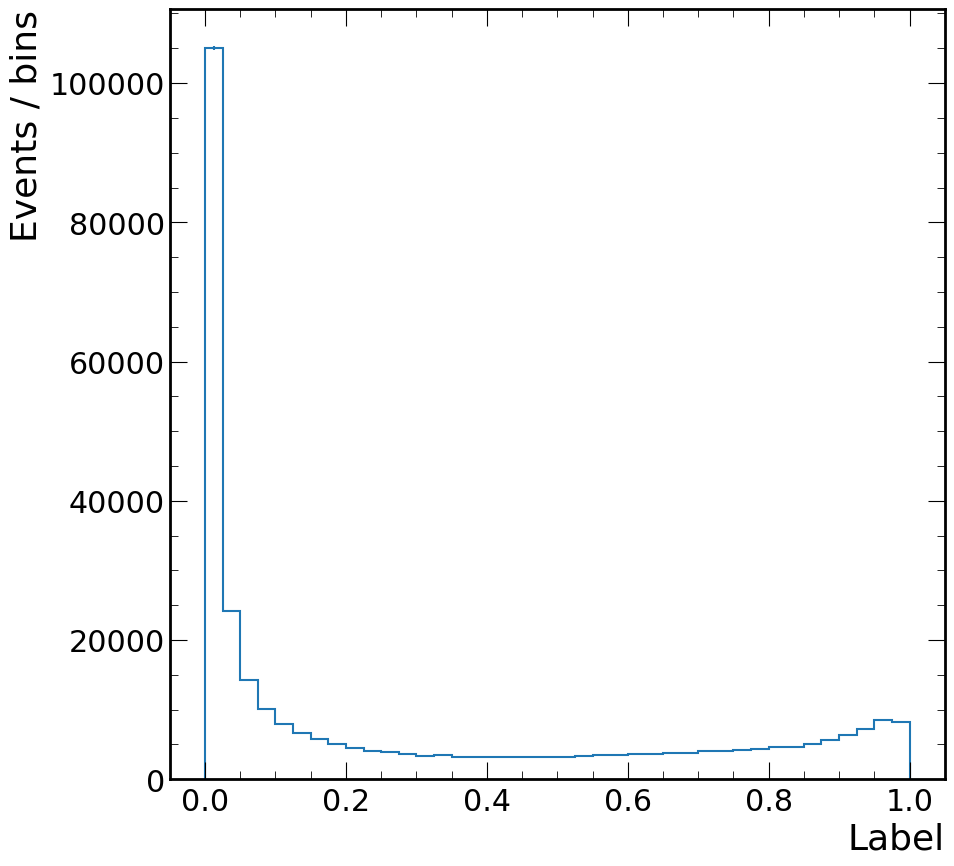

In [233]:
f, ax = plt.subplots(figsize=(10,10))

nbin, xmin, xmax = 40, 0, 1
hist = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
num_bell = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv + inclParTMDV1_probTopbWtauev + inclParTMDV1_probTopbWtaumv'
discr = f'({num}) / ({num} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)'
tagger_arr = ak.numexpr.evaluate(discr, events[ak.num(events.FatJet) >= 1].FatJet[:, 0])
hist.fill(tagger_arr[~np.isnan(tagger_arr)])
# hist.fill(arr_clean)
# 

content, yerr = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr)
ax.set_xlabel('Label', ha='right', x=1.0); ax.set_ylabel('Events / bins', ha='right', y=1.0);


### find tlb jet tagger distribution


In [234]:
deltaR = 0.8

d_PDGID = 1
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

# finding the two gen tops
tops = events.GenPart[
    (abs(events.GenPart.pdgId) == TOP_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
]


In [235]:
num_jets = 1
fatjets = events.FatJet
leading_fatjets = ak.pad_none(fatjets, num_jets, axis=1)[:, :num_jets]

In [236]:
leading_fatjets

<FatJetArray [[FatJet], [FatJet, ... [FatJet]] type='330706 * var * ?fatJet'>

In [70]:
max(ak.num(leading_fatjets))

1

In [97]:
ws.children.pdgId[:,0]

<Array [[2, -1], [12, -11, ... 4, -3], [4, -3]] type='1099006 * option[var * ?in...'>

In [94]:
a = np.abs(ws.children.pdgId[:,0]) > 5

In [96]:
a[0]

<Array [False, False] type='2 * ?bool'>

In [98]:
a = (np.all(np.abs(ws.children.pdgId[:,0]) > 5,axis = 1) & (np.all(np.abs(ws.children.pdgId[:,1]) <= 5,axis = 1))) | (np.all(np.abs(ws.children.pdgId[:,1]) > 5,axis = 1) & (np.all(np.abs(ws.children.pdgId[:,0]) <= 5,axis = 1)))

In [112]:
ws.children.pdgId

<Array [[[2, -1], [1, -2, ... 4, -3], [1, -2]]] type='1099006 * var * option[var...'>

In [125]:
a = np.all(np.abs(ws.children.pdgId[:,0]) > 5,axis = 1)

In [126]:
c = np.all(np.abs(ws.children.pdgId[:,1]) > 5,axis = 1)

In [127]:
b = np.all(np.abs(ws.children.pdgId[:,0]) <= 5,axis = 1)

In [128]:
d = np.all(np.abs(ws.children.pdgId[:,1]) <= 5,axis = 1)

In [129]:
ws[(a & d) | (c & b)].children.pdgId[0]

<Array [[4, -1], [11, -12]] type='2 * option[var * ?int32[parameters={"__doc__":...'>

In [99]:
ak.sum(a)

487952

In [133]:
ws

<GenParticleArray [[GenParticle, ... GenParticle]] type='1099006 * var * ?genPar...'>

In [151]:
lep_top_sel

<Array [False, False, False, ... True, False] type='1099006 * ?bool'>

In [237]:
tops_children = tops.distinctChildren
tops_children = tops_children[tops_children.hasFlags(GEN_FLAGS)]
ws = ak.flatten(tops_children[np.abs(tops_children.pdgId) == W_PDGID], axis=2)

#only select semi-lep ttbar for simplicity
lep_top_sel = ((np.all(np.abs(ws.children.pdgId[:,0]) > 5,axis = 1) & (np.all(np.abs(ws.children.pdgId[:,1]) <= 5,axis = 1))) | (np.all(np.abs(ws.children.pdgId[:,1]) > 5,axis = 1) & (np.all(np.abs(ws.children.pdgId[:,0]) <= 5,axis = 1))))
#find the leptonic W
lep_ws_sel = np.all(np.abs(ws[lep_top_sel].children.pdgId) > 5, axis=2)
lep_ws = ak.flatten(ws[lep_top_sel][lep_ws_sel])
#find lepton
lepton_sel = (np.abs(lep_ws.children.pdgId) == 11) | ((np.abs(lep_ws.children.pdgId) == 13)) | ((np.abs(lep_ws.children.pdgId) == 15))
lepton = lep_ws.children[lepton_sel]
#find leptonic top
lep_tops = tops[lep_top_sel][lep_ws_sel]
lep_top_children = ak.flatten(lep_tops.children, axis=1)
lep_bs = lep_top_children[np.abs(lep_top_children.pdgId) == 5]


In [203]:
a = lep_bs.pdgId/np.abs(lep_bs.pdgId)

In [204]:
b = lepton.pdgId/np.abs(lepton.pdgId)

In [207]:
np.sum(a + b)

0.0

In [194]:
lep_tops.children

<GenParticleArray [[[GenParticle, ... GenParticle]]] type='487952 * option[var *...'>

In [193]:
lep_top_children

<GenParticleArray [[GenParticle, ... GenParticle]] type='487952 * option[var * ?...'>

In [184]:
lep_tops = tops[lep_top_sel][lep_ws_sel]

In [188]:
lep_tops[0].children.children.pdgId

<Array [[[2, -5, -2], [-24]]] type='1 * option[var * option[var * ?int32[paramet...'>

In [183]:
lep_ws_sel

<Array [[False, True], ... [False, True]] type='487952 * option[var * ?bool]'>

In [182]:
lep_tops.children.pdgId[0]

<Array [[5, 24], [-5, -24]] type='2 * var * ?int32[parameters={"__doc__": "PDG i...'>

In [173]:
lepton.pdgId[100]

<Array [-13] type='1 * ?int32[parameters={"__doc__": "PDG id"}]'>

In [159]:
lep_ws_sel

<Array [[False, True], ... [False, True]] type='487952 * option[var * ?bool]'>

In [168]:
ak.num(lep_ws.children)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='487952 * ?int64'>

In [148]:
lep_ws = ak.flatten(ws[lep_top_sel],axis = 1)

In [153]:
ws[lep_top_sel][0].children.pdgId

<Array [[4, -1], [11, -12]] type='2 * option[var * ?int32[parameters={"__doc__":...'>

In [149]:
lep_ws.children.pdgId[0]

<Array [4, -1] type='2 * ?int32[parameters={"__doc__": "PDG id"}]'>

In [108]:
ws.children[0].pdgId

<Array [[2, -1], [1, -2]] type='2 * option[var * ?int32[parameters={"__doc__": "...'>

In [146]:
ws[lep_top_sel].children[0].pdgId

<Array [[4, -1], [11, -12]] type='2 * option[var * ?int32[parameters={"__doc__":...'>

In [141]:
lep_ws.children.pdgId

<Array [[4, -1], [11, -12, ... -3], [11, -12]] type='975904 * option[var * ?int3...'>

In [137]:
ws[lep_top_sel].children.pdgId[0]

<Array [[4, -1], [11, -12]] type='2 * option[var * ?int32[parameters={"__doc__":...'>

In [238]:
def pad_val(
    arr: ak.Array,
    target: int,
    value: float,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    return ret.to_numpy() if to_numpy else ret

leading_fatjets_leptop = leading_fatjets[lep_top_sel]

lep_jet_match = ak.flatten(
    pad_val(lepton.delta_r(leading_fatjets_leptop[:, 0]) < deltaR, 1, False, axis=1, to_numpy=False)
)
lep_b_jet_match = ak.flatten(
    pad_val(lep_bs.delta_r(leading_fatjets_leptop[:, 0]) < deltaR, 1, False, axis=1, to_numpy=False)
)
# merged_top_jet_match = had_w_jet_match * had_b_jet_match


In [241]:
leading_fatjets_leptop

<FatJetArray [[FatJet], [FatJet, ... [FatJet]] type='142121 * option[var * ?fatJet]'>

### plot tagger distri

In [227]:
ak.sum(lep_jet_match * lep_b_jet_match)

12517

In [239]:
ak.numexpr.evaluate(discr, leading_fatjets_leptop[lep_jet_match * lep_b_jet_match])

<Array [[0.975], [0.494], ... [0.615], [0.891]] type='12517 * option[var * ?floa...'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

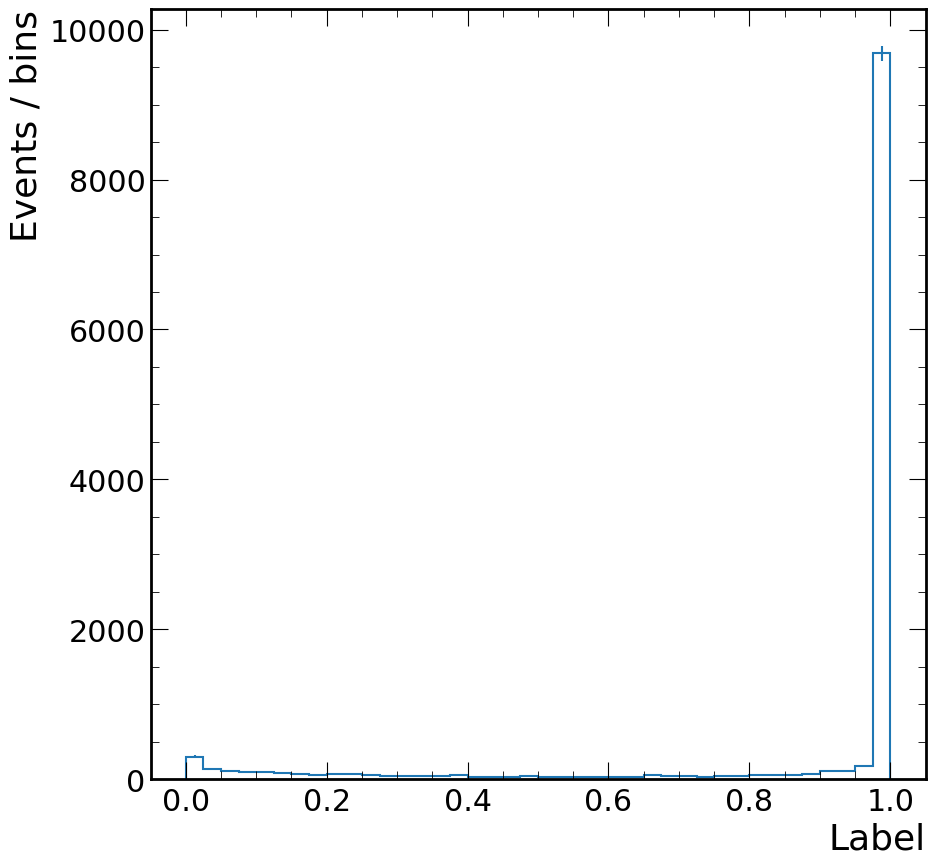

: 

In [243]:
f, ax = plt.subplots(figsize=(10,10))

nbin, xmin, xmax = 40, 0, 1
hist = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
num_bell = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv + inclParTMDV1_probTopbWtauev + inclParTMDV1_probTopbWtaumv'
discr = f'({num_bl}) / ({num_bl} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)'
tagger_arr = ak.numexpr.evaluate(discr, leading_fatjets_leptop[lep_jet_match * lep_b_jet_match])[:,0]
hist.fill(tagger_arr[~np.isnan(tagger_arr)])
# hist.fill(arr_clean)
# 

content, yerr = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr)
ax.set_xlabel('Label', ha='right', x=1.0); ax.set_ylabel('Events / bins', ha='right', y=1.0);


### some check

In [63]:
num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
num_bell = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv + inclParTMDV1_probTopbWtauev + inclParTMDV1_probTopbWtaumv'
discr = f'({num}) / ({num} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)'
arr = ak.numexpr.evaluate(discr, events[ak.num(events.FatJet) >= 1].FatJet[:, 0])
np.quantile(arr[~np.isnan(arr)], q=0.99)
# np.quantile(arr,q=0.9)

0.7933419144153604

In [35]:
arr

<Array [0.00542, 0.00836, ... 0.12, 0.000117] type='330706 * float32'>

In [39]:
arr_clean = arr[~np.isnan(arr)]

In [40]:
arr_clean

<Array [0.00542, 0.00836, ... 0.12, 0.000117] type='315428 * float32'>

In [41]:
np.quantile(arr_clean, q = 1 - 1e-2)

0.9999935030937195

In [11]:
arr

<Array [0.00152, 0.00195, ... 9.94e-05] type='330061 * float32'>

In [23]:
if ak.any(np.isnan(arr)): print("contain NaN")


contain NaN


In [19]:
nan_indices = np.where(np.isnan(arr))[0]

In [20]:
nan_indices

<Array [68, 94, 131, ... 330632, 330640] type='15278 * int64'>

In [22]:
events[ak.num(events.FatJet) >= 1].FatJet[:, 0][68].inclParTMDV1_probTopbWev

0.0

In [50]:
num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
ak.numexpr.evaluate(num_bl, events[ak.num(events.FatJet) >= 1].FatJet[:, 0])[68]

0.0

In [7]:
ak.fields(events.FatJet)

['ParticleNetMDraw_probQCDb',
 'ParticleNetMDraw_probQCDbb',
 'ParticleNetMDraw_probQCDc',
 'ParticleNetMDraw_probQCDcc',
 'ParticleNetMDraw_probQCDothers',
 'ParticleNetMDraw_probXbb',
 'ParticleNetMDraw_probXcc',
 'ParticleNetMDraw_probXqq',
 'ParticleNetraw_probHbb',
 'ParticleNetraw_probHcc',
 'ParticleNetraw_probHqqqq',
 'ParticleNetraw_probQCDb',
 'ParticleNetraw_probQCDbb',
 'ParticleNetraw_probQCDc',
 'ParticleNetraw_probQCDcc',
 'ParticleNetraw_probQCDothers',
 'ParticleNetraw_probTbc',
 'ParticleNetraw_probTbcq',
 'ParticleNetraw_probTbel',
 'ParticleNetraw_probTbmu',
 'ParticleNetraw_probTbq',
 'ParticleNetraw_probTbqq',
 'ParticleNetraw_probTbta',
 'ParticleNetraw_probWcq',
 'ParticleNetraw_probWqq',
 'ParticleNetraw_probZbb',
 'ParticleNetraw_probZcc',
 'ParticleNetraw_probZqq',
 'area',
 'btagCMVA',
 'btagCSVV2',
 'btagDDBvL',
 'btagDDBvLV2',
 'btagDDBvL_noMD',
 'btagDDCvB',
 'btagDDCvBV2',
 'btagDDCvB_noMD',
 'btagDDCvL',
 'btagDDCvLV2',
 'btagDDCvL_noMD',
 'btagDeepB',


### find tbl gen-matching information

### processing

In [8]:
from coffea import processor, hist
from functools import partial

class TblNodeAnalyzeProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset = hist.Cat("dataset", "dataset")

        self._accumulator = processor.dict_accumulator({
            # defination of cutflow (nested dictionary of int) copied from the example
            'cutflow': processor.defaultdict_accumulator(
                partial(processor.defaultdict_accumulator, int)
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        out = self.accumulator.identity()
        dataset = events.metadata['dataset']
        out['cutflow'][dataset]['all'] += len(events)

        fname = f"coffea_output/{dataset}/{events.metadata['filename'].split('/')[-1].replace('.root','')}_{int(events.metadata['entrystop'])}.root"

        # lepton selection
        lep_sel = (ak.num(events.Electron) + ak.num(events.Muon) == 1) & (ak.num(events.Jet) >= 2) & (ak.num(events.FatJet) >= 1)
        events = events[lep_sel]

        # the lepton object
        lep = ak.concatenate([events.Electron, events.Muon], axis=1)[:, 0]
        lep_isel = ak.num(events.Electron) > 0

        # jet and MET selection
        jet_sel = (events.Jet.pt[:, 0] > 50) & (events.Jet.pt[:, 1] > ak.where(lep_isel, 40, 50))
        jet_btagsel = ak.num(events.Jet[events.Jet.btagDeepFlavB > 0.3040]) >= 1 # MP in 2017 deepjet, https://btv-wiki.docs.cern.ch/ScaleFactors/UL2017/#ak4-b-tagging

        met_sel = events.MET.pt > ak.where(lep_isel, 60, 70)

        # fatjet selection
        fatjet = events.FatJet[:, 0]
        fatjet_sel = (fatjet.pt > 400) & (fatjet.msoftdrop > 105) & (fatjet.msoftdrop < 210)

        # fatjet top-tagging discr. We use ParT (MD) to construct the t->bqq discr and manually cut at 1% mistag WP
        num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
        discr = f'({num}) / ({num} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)'
        fatjet_toptagsel = ak.numexpr.evaluate(discr, fatjet) > 0.79 # 1% mistag rate on QCD

        # selection based on all objects
        # sel = jet_sel & jet_btagsel & met_sel & fatjet_sel & fatjet_toptagsel
        sel = jet_sel & jet_btagsel & met_sel # let's remove the fatjet sel for now
        events = events[sel]

        # ==== Now we finished all selections ====

        # define objects
        fj1 = events.FatJet[:, 0]
        fj2 = events.mask[ak.num(events.FatJet) >= 2].FatJet[:, 1] # use mask since a second fj may not exist

        jets = events.Jet
        lep = ak.concatenate([events.Electron, events.Muon], axis=1)[:, 0]
        lep_isel = ak.num(events.Electron) > 0

        # t->bqq discr
        num = 'inclParTMDV1_probTopbWqq0c + inclParTMDV1_probTopbWqq1c + inclParTMDV1_probTopbWq0c + inclParTMDV1_probTopbWq1c'
        fj1_ParTV1_discr_bqqvsQCD = ak.numexpr.evaluate(f'({num}) / ({num} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)', fj1)
        
        # t->bl discr
        num_bl = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv'
        num_bell = 'inclParTMDV1_probTopbWev + inclParTMDV1_probTopbWmv + inclParTMDV1_probTopbWtauev + inclParTMDV1_probTopbWtaumv'
        fj2_ParTV1_discr_blvsQCD = ak.numexpr.evaluate(f'({num_bl}) / ({num_bl} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)', fj2)
        fj2_ParTV1_discr_bellvsQCD = ak.numexpr.evaluate(f'({num_bell}) / ({num_bell} + inclParTMDV1_probQCDbb + inclParTMDV1_probQCDcc + inclParTMDV1_probQCDb + inclParTMDV1_probQCDc + inclParTMDV1_probQCDothers)', fj2)

        # the 2D reconstruction workflow

        pair = ak.cartesian([lep, jets[jets.pt > 15]]) # all lep-jet pair with jet pt > 15
        dr_pair = pair['1'].delta_r(pair['0'])
        mindr_ind = ak.singletons(ak.argmin(dr_pair, axis=1))

        jet_closest = pair['1'][mindr_ind][:, 0]
        mindr = dr_pair[mindr_ind][:, 0]

        ptrel = lep.pt * np.abs(np.sin(lep.phi - jet_closest.phi)) # lep pt *perpendicular* to jet axis

        # construct output variables
        output = {}
        output['fj1_pt'] = fj1.pt
        output['fj1_eta'] = fj1.eta
        output['fj1_phi'] = fj1.phi
        output['fj1_sdmass'] = fj1.msoftdrop
        output['fj2_pt'] = ak.fill_none(fj2.pt, 0)
        output['fj2_eta'] = ak.fill_none(fj2.eta, 0)
        output['fj2_phi'] = ak.fill_none(fj2.phi, 0)
        output['fj2_sdmass'] = ak.fill_none(fj2.msoftdrop, 0)

        output['fj1_ParTV1_discr_bqqvsQCD'] = ak.fill_none(fj1_ParTV1_discr_bqqvsQCD, 0)
        output['fj2_ParTV1_discr_blvsQCD'] = ak.fill_none(fj2_ParTV1_discr_blvsQCD, 0)
        output['fj2_ParTV1_discr_bellvsQCD'] = ak.fill_none(fj2_ParTV1_discr_bellvsQCD, 0)

        output['dr_fj12'] = ak.fill_none(fj1.delta_r(fj2), -1)

        output['lep_pt'] = lep.pt
        output['lep_eta'] = lep.eta
        output['lep_phi'] = lep.phi
        output['lep_isel'] = lep_isel
        output['lep_mindr_jet'] = mindr
        output['lep_ptrel_jet'] = ptrel

        output['deta_jet12'] = jets[:, 0].eta - jets[:, 1].eta

        # store root
        print(fname)
        os.makedirs(os.path.dirname(fname), exist_ok=True)
        with uproot.recreate(fname) as fout:
            output_root = {}
            for bname in output.keys():
                if not output[bname].fields:
                    output_root[bname] = ak.packed(ak.without_parameters(output[bname]))
                else:
                    b_nest = {}
                    for n in output[bname].fields:
                        b_nest[n] = ak.packed(ak.without_parameters(output[bname][n]))
                    output_root[bname] = ak.zip(b_nest)
            fout["tree"] = output_root

        out['cutflow'][dataset]['passed'] += len(events)
        return out
    
    def postprocess(self, accumulator):
        return accumulator

/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [9]:
import glob
fileset = {
    'ttbar': glob.glob('/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/TTJets/TTJets/*0.root'),
    'qcd': glob.glob('/data/bond/fudawei/public/customizedNanoAOD/output/mc/2017/QCD/QCD_HT1000to1500/*.root'),
}

In [10]:
result = processor.run_uproot_job(
    fileset=fileset,
    treename="Events",
    processor_instance=TblNodeAnalyzeProcessor(),
    executor=processor.futures_executor,
    executor_args={"schema": NanoAODSchema, "workers": 60},
)

/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

coffea_output/qcd/merged_6_116913.root
coffea_output/qcd/merged_6_233826.root
coffea_output/ttbar/merged_130_99931.root
coffea_output/ttbar/merged_130_199862.root
coffea_output/ttbar/merged_130_299793.root
coffea_output/ttbar/merged_130_399724.root
coffea_output/qcd/merged_5_419072.root
coffea_output/qcd/merged_5_523840.root
coffea_output/qcd/merged_5_314304.root
coffea_output/qcd/merged_5_209536.root
coffea_output/qcd/merged_5_628603.root
coffea_output/qcd/merged_5_104768.root
coffea_output/qcd/merged_2_427596.root
coffea_output/qcd/merged_2_534495.root
coffea_output/qcd/merged_2_320697.root
coffea_output/qcd/merged_2_641389.root
coffea_output/qcd/merged_2_106899.root
coffea_output/qcd/merged_2_213798.root
coffea_output/qcd/merged_0_101415.root
coffea_output/qcd/merged_4_479785.root
coffea_output/qcd/merged_4_671698.root
coffea_output/qcd/merged_4_287871.root
coffea_output/qcd/merged_4_575742.root
coffea_output/qcd/merged_4_383828.root
coffea_output/qcd/merged_4_95957.root
coffea_outp